In [ ]:
### 구글 드라이브 마운트
## Colab으로 문제 풀이를 하시는 분들만 실행해 주시면 됩니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. GBM**
- 물 가용성 데이터를 활용합니다
- `water_potability.csv` 데이터셋을 다운로드 후 실습을 진행해 주세요.


## **1-1. 빈칸을 채워주세요. (5개)**

- 아래의 셀을 실행시킨 후에 실습을 진행해주세요
- 데이터 파일 경로 확인해주세요

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
### 데이터 준비

# 데이터 불러오기
water = pd.read_csv('./water_potability.csv') # 파일 경로 확인
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2293 non-null   float64
 1   Hardness         2293 non-null   float64
 2   Solids           2293 non-null   float64
 3   Chloramines      2293 non-null   float64
 4   Sulfate          2293 non-null   float64
 5   Conductivity     2293 non-null   float64
 6   Organic_carbon   2293 non-null   float64
 7   Trihalomethanes  2293 non-null   float64
 8   Turbidity        2293 non-null   float64
 9   Potability       2293 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 179.3 KB


In [ ]:
# Feature, Target 분리
X = water.drop('Potability', axis = 1)
y = water['Potability']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

print(X_train.shape, X_test.shape)

(1834, 9) (459, 9)


- GradientBoostingClassifier 클래스를 이용하여 `물 가용성 데이터 세트` 예측/분류
- GBM 학습 시간 측정


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0) ### 답안
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy)) ### 답안
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time)) ### 답안

GBM 정확도: 0.6536
GBM 수행 시간: 1.1 초 


### **GridSearchCV를 이용한 하이퍼 파라미터 최적화**

📍GBM 하이퍼 파라미터
  - `loss`: 경사 하강법에서 사용할 비용 함수 지정
  - `learning_rate`: GBM이 학습을 진행할 때마다 적용하는 학습률
  - `n_estimators`: weak learner의 개수
  - `subsample`: weak learner가 학습에 사용하는 데이터의 샘플링 비율

## **1.2 아래의 파라미터가 의미하는 것을 각각 서술하세요.**

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [0.05, 0.1],
}

grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 100}
최고 예측 정확도: 0.6423


### 답안
1) 'n_estimators':[100, 500]
- weak learner의 개수를 의미한다.
- 100개와 500개의 weak learner를 시도한다는 것을 알 수 있다.

2)'learning_rate' : [ 0.05, 0.1]
- GBM이 학습을 진행할 때마다 적용하는 학습률로, Weak learner가 순차적으로 오류 값을 보정해나가는데 적용하는 계수이다.
- 0.05와 0.1의 두 가지의 학습률을 시도하여 최적의 학습률을 찾으려고함을 알 수 있다.

# **2. XGBoost**

- 타이타닉 데이터를 활용합니다
- `titanic.csv` 데이터셋을 다운로드 후 실습을 진행해 주세요.

**데이터 준비**

In [12]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Titanic 데이터셋
titanic_df = pd.read_csv('./titanic.csv')

# 관련 없는 열 또는 고유한 값이 너무 많은 열 제거
titanic_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# 결측값 채우기
titanic_df.fillna(method='ffill', inplace=True)  # Filling NaN values with forward fill method

# 범주형 열을 숫자로 변환(Label Encoding)
label_encoders = {}
for col in ['Sex', 'Embarked']:
    label_encoders[col] = LabelEncoder()
    titanic_df[col] = label_encoders[col].fit_transform(titanic_df[col])

In [14]:
# features과 target variable 분리
X_features = titanic_df.drop(columns=['Survived'])
y_label = titanic_df['Survived']

# 학습용 데이터, 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

# 데이터를 DMatrix 형식으로 변환
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label = y_test)

(712, 8) (179, 8)


## **2-1. XGBoost의 하이퍼 파라미터 설정에 따라 파라미터 목록을 완성해 주세요.**

- 트리의 최대 깊이: 5  
- 학습률(eta): 0.05  
- 이진 분류 문제  
  - 오류 함수의 평가 성능 지표는 `error`
- 부스팅 반복 횟수: 500회  

In [15]:
### 답안

# Parameters for XGBoost model
params = {'max_depth':5,
          'eta':0.05,
          'objective':'binary:logistic',
          'eval_metric':'error',
          'early_stopping_rounds':100
         }

# 부스팅 반복 횟수 지정
num_rounds = 500

- 아래 코드들을 실행하여 결과를 확인해 보세요!

In [16]:
# XGBoost 모델 학습
wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                      evals=wlist,  verbose_eval = 0)

# 확률 예측
pred_probs = xgb_model.predict(dtest)
print('Predicted probabilities (first 10):')
print(np.round(pred_probs[:10],3))

# 확률을 예측값으로 변환
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('Predicted labels (first 10):', preds[:10])

Predicted probabilities (first 10):
[0.331 0.011 0.054 0.288 0.987 0.03  0.825 0.622 0.005 0.023]
Predicted labels (first 10): [0, 0, 0, 0, 1, 0, 1, 1, 0, 0]


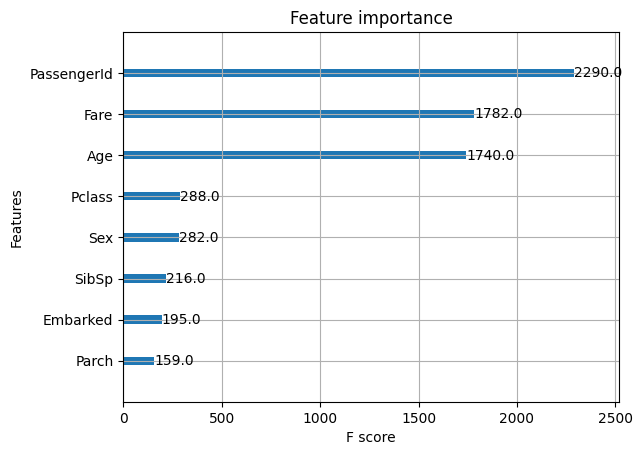

In [17]:
# Feature Importance 그리기

plot_importance(xgb_model)
plt.show()

## **2.2 파이썬 래퍼를 사용하여 XGBoost 모델을 학습할 때 입력 데이터를 특정 형식으로 변환하여 사용합니다.이 변환을 수행하는 함수는 무엇입니까?**

### **답안**
> xgb.`DMatrix()`

## **2.3. 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier를 사용하여 XGBoost 분류기를 학습하는 코드를 완성하세요.**
- 추정기 개수: 200
- 학습률: 0.1
- 트리의 최대 깊이: 4

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [19]:
# XGBoost 모델 학습
xgb_wrapper = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 4) ### 답안
xgb_wrapper.fit(X_train, y_train)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

- 아래 코드를 실행하여 결과를 확인해 보세요!

In [20]:
# 분류 모델 평가 함수 정의 및 호출

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [21]:
# 모델 평가 수행

get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[96 11]
 [23 49]]
정확도: 0.8101, 정밀도: 0.8167, 재현율: 0.6806,    F1: 0.7424, AUC:0.8374


## **2-4. 아래 코드에서 조기 중단 설정이 어떻게 변경되며, 이러한 변화가 예측 성능에 미칠 수 있는 영향에 대해 서술하세요.**



In [22]:
xgb_wrapper = XGBClassifier(n_estimators = 300, learning_rate=0.1, max_depth=6)
evals = [(X_test, y_test)]

In [23]:
### 첫 번째 학습

# XGBClassifier 모델 학습 (조기 중단 설정)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

[0]	validation_0-logloss:0.63356
[1]	validation_0-logloss:0.60037
[2]	validation_0-logloss:0.57423
[3]	validation_0-logloss:0.55243
[4]	validation_0-logloss:0.53491
[5]	validation_0-logloss:0.52240
[6]	validation_0-logloss:0.51087
[7]	validation_0-logloss:0.50389
[8]	validation_0-logloss:0.49613
[9]	validation_0-logloss:0.48904
[10]	validation_0-logloss:0.48345
[11]	validation_0-logloss:0.47826
[12]	validation_0-logloss:0.47273
[13]	validation_0-logloss:0.46838
[14]	validation_0-logloss:0.46477
[15]	validation_0-logloss:0.46139
[16]	validation_0-logloss:0.45919
[17]	validation_0-logloss:0.45758
[18]	validation_0-logloss:0.45632
[19]	validation_0-logloss:0.45515
[20]	validation_0-logloss:0.45369
[21]	validation_0-logloss:0.45133
[22]	validation_0-logloss:0.44978
[23]	validation_0-logloss:0.44714
[24]	validation_0-logloss:0.44553
[25]	validation_0-logloss:0.44383
[26]	validation_0-logloss:0.44302
[27]	validation_0-logloss:0.44236
[28]	validation_0-logloss:0.44304
[29]	validation_0-loglos

In [24]:
### 두 번째 학습

# 조기 중단 설정 변경
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.63356
[1]	validation_0-logloss:0.60037
[2]	validation_0-logloss:0.57423
[3]	validation_0-logloss:0.55243
[4]	validation_0-logloss:0.53491
[5]	validation_0-logloss:0.52240
[6]	validation_0-logloss:0.51087
[7]	validation_0-logloss:0.50389
[8]	validation_0-logloss:0.49613
[9]	validation_0-logloss:0.48904
[10]	validation_0-logloss:0.48345
[11]	validation_0-logloss:0.47826
[12]	validation_0-logloss:0.47273
[13]	validation_0-logloss:0.46838
[14]	validation_0-logloss:0.46477
[15]	validation_0-logloss:0.46139
[16]	validation_0-logloss:0.45919
[17]	validation_0-logloss:0.45758
[18]	validation_0-logloss:0.45632
[19]	validation_0-logloss:0.45515
[20]	validation_0-logloss:0.45369
[21]	validation_0-logloss:0.45133
[22]	validation_0-logloss:0.44978
[23]	validation_0-logloss:0.44714
[24]	validation_0-logloss:0.44553
[25]	validation_0-logloss:0.44383
[26]	validation_0-logloss:0.44302
[27]	validation_0-logloss:0.44236
[28]	validation_0-logloss:0.44304
[29]	validation_0-loglos

### **답안**  
- 조기 중단값을 가리키는 `early_stopping_rounds`가 100에서 10으로 줄었다.
- 이렇게 급격하게 조기 중단값을 줄이는 경우 예측 성능이 저하될 우려가 있다.

# **3. LightGBM**

## **3-1.**
- 해당 실습에서는 `피마 당뇨병` 데이터를 활용합니다.
- `diabetes.csv` 데이터셋을 다운로드 후 실습을 진행해 주세요.

In [ ]:
### 실습을 위한 lgbm 다운그레이드
# 아래 코드를 실행시켜 주세요.

!pip install lightgbm==3.3.2

In [ ]:
# 제대로 다운그레이드 되었는지 확인

import lightgbm
print(lightgbm.__version__)

3.3.2


### **Step1) 데이터 로드**


In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import early_stopping

In [ ]:
### 아래 코드를 실행시켜 주세요.
## csv 파일 경로를 알맞게 수정해 주세요.

# data load: 피마 당뇨병 데이터 셋
diabetes = pd.read_csv('./diabetes.csv')
print(diabetes['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


### **Step 2) 데이터 Split**
- 아래 코드를 실행시켜 주세요.

In [ ]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

### **Step 3) 모델 학습**
- 아래 코드의 빈칸을 채워주세요.  
(힌트 : 교재 p.251)



In [ ]:
lgbm_wrapper = LGBMClassifier(n_estimators = 400)

evals = [(X_test, y_test)] # 답안
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
                 eval_metric='logloss', eval_set=evals, verbose=True)

[1]	valid_0's binary_logloss: 0.630031
[2]	valid_0's binary_logloss: 0.607335
[3]	valid_0's binary_logloss: 0.585795
[4]	valid_0's binary_logloss: 0.566393
[5]	valid_0's binary_logloss: 0.551676
[6]	valid_0's binary_logloss: 0.541892
[7]	valid_0's binary_logloss: 0.535487
[8]	valid_0's binary_logloss: 0.526912
[9]	valid_0's binary_logloss: 0.518037
[10]	valid_0's binary_logloss: 0.512287
[11]	valid_0's binary_logloss: 0.511588
[12]	valid_0's binary_logloss: 0.504413
[13]	valid_0's binary_logloss: 0.49867
[14]	valid_0's binary_logloss: 0.496196
[15]	valid_0's binary_logloss: 0.492987
[16]	valid_0's binary_logloss: 0.489374
[17]	valid_0's binary_logloss: 0.491211
[18]	valid_0's binary_logloss: 0.491578
[19]	valid_0's binary_logloss: 0.489177
[20]	valid_0's binary_logloss: 0.488728
[21]	valid_0's binary_logloss: 0.486497
[22]	valid_0's binary_logloss: 0.48802
[23]	valid_0's binary_logloss: 0.487214
[24]	valid_0's binary_logloss: 0.488736
[25]	valid_0's binary_logloss: 0.490997
[26]	valid_

LGBMClassifier(n_estimators=400)

### **Step 4) 예측**
- 아래 코드를 실행시켜 주세요.

In [ ]:
# 예측
y_pred = lgbm_wrapper.predict(X_test)

# 정확도 확인
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy:.3f}')

accuracy: 0.747


## **3-2. 예측 시각화**


### **문제**
- 다음과 같은 코드 오류가 발생했습니다.
  - 오류를 해결할 수 있는 코드를 한 줄 추가해 주세요.

```
NameError                                 Traceback (most recent call last)
Cell In[2], line 5
      2 get_ipython().run_line_magic('matplotlib', 'inline')
      4 fig, ax = plt.subplots(figsize=(10, 12))
----> 5 plot_importance(lgbm_wrapper, ax=ax)
      6 plt.show()

NameError: name 'plot_importance' is not defined
```

(힌트 : 교재 p.259)


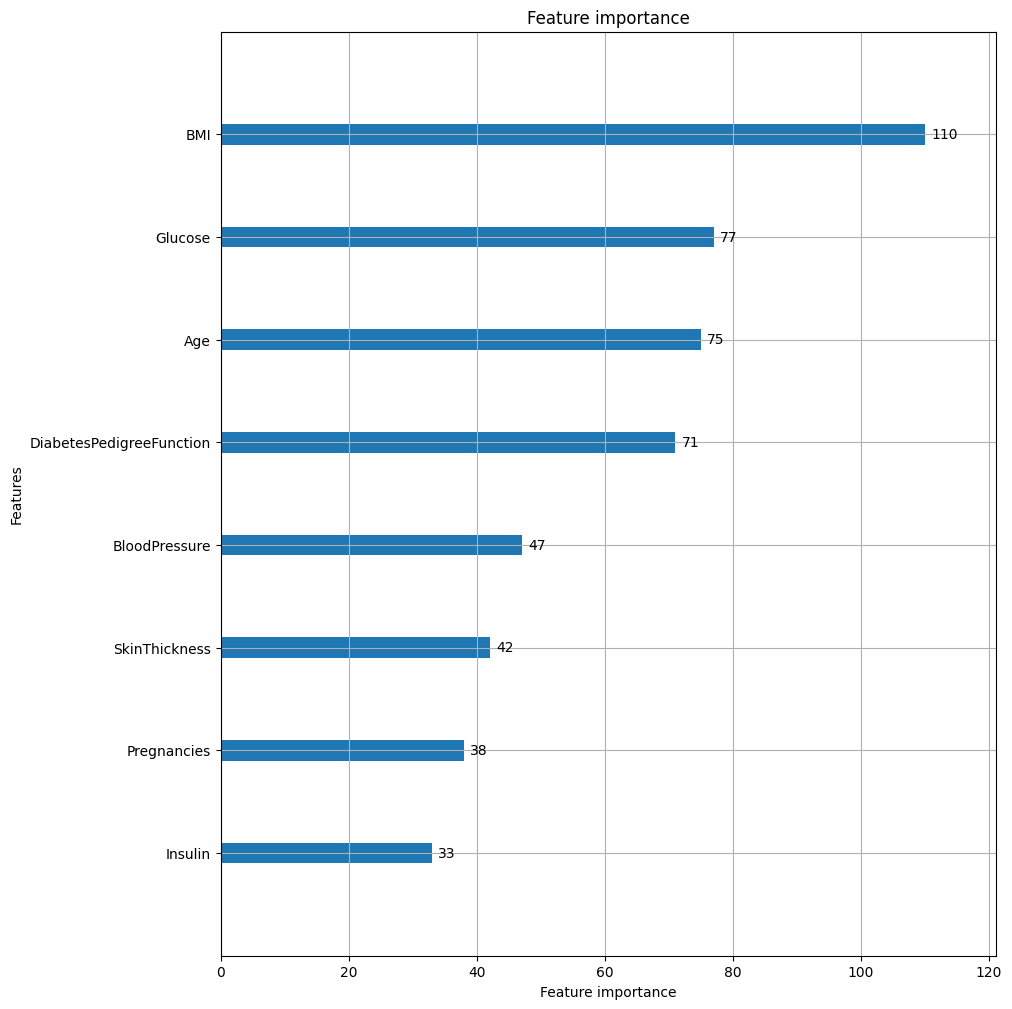

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 필요한 코드를 추가해 주세요.

from lightgbm import plot_importance ### 답안

# 시각화
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

# **4. 스태킹**

## **4-1. 기본 스태킹 모델**

- 아래 코드를 실행시켜 주세요.

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier 생성
lr_final = LogisticRegression(C=10)

### **Step 1) 스태킹에 활용할 개별 모델을 학습시켜 주세요.**

In [ ]:
### 답안

knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

- 아래 코드를 실행시켜 주세요.


In [ ]:
# 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.6688
랜덤 포레스트 정확도: 0.7468
결정 트리 정확도: 0.6818
에이다부스트 정확도: 0.7273


### **Step 2) 다음과 같이 출력되도록 `transpose`를 이용해 행과 열의 위치를 교환하는 코드를 작성해 주세요.**
   
```
(4, 154)
(154, 4)
```

(힌트 : 교재 p.281)

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환하는 코드를 작성해 주세요.
# 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듭니다.

pred = np.transpose(pred) ### 답안
print(pred.shape)

- 아래의 코드를 실행시켜 주세요.

In [ ]:
# 최종 메타 모델 학습/예측

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

## **4-2. CV 기반 스태킹**



- CV 세트 기반의 스태킹은 최종 메타 모델을 위한 데이터 세트를 만들 때, 교차 검증 기반으로 예측된 결과 데이터 세트를 이용합니다.
- 또한 CV 세트 기반의 스태킹 과정은 크게 Step1과 Step2, 두가지로 나눌 수 있습니다.

### **Step1)**

**개별 모델**
- 교차검증으로 메타모델을 위한 학습용  데이터, 테스트용 데이터 생성

### **Step 2)**
- 학습용 데이터: 스태킹 형태로 합치기 → 최종 학습용 데이터 세트 생성
- 테스트용 데이터 : 스태킹 형태로 합치기 → 최종 테스트 데이터 세트 생성

**최종 모델**
- 최종 학습용 데이터 세트 + 원본 학습 데이터의 레이블 데이터를 기반으로 학습
→ 최종 테스트 데이터 세트로 예측 + 원본 테스트 데이터의 레이블 데이터와 비교해 평가   
<br/>


---

### **문제**
그렇다면,
<br/>
> **“학습용 데이터를 N개의 폴드로 나눈다”**
는 Step1과 Step2중 어느 단계에 속할까요?   

힌트 : 교재 p.283

### **👇정답을 적어주세요!**

정답: Step 1

# 5. **HyperOpt**


- 사이킷런의 `boston 주택 가격 데이터`를 사용합니다.
- 아래의 셀을 실행시킨 후 실습을 진행해 주세요.

In [ ]:
import pandas as pd
import numpy as np
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load dataset

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

## **5.1. `train_test_split()`를 사용하여 훈련 세트와 테스트 세트로 나누어 주세요.**

- random_state = 207
- train: test = 8:2

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, target,
                                                    random_state=207, test_size=0.2)

---

- 이제 평가 함수를 정의하겠습니다.  
- 교재와 다르게 Regression 예측을 진행할 예정이기 때문에,` RMSE` 평가 지표를 함수로 만들어 정의합니다.

In [ ]:
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## **5.2. search_space의 빈칸을 채워주세요.**

- `max_depth`: 5에서 20까지 1간격으로
- `min_child_weight`: 1에서 10까지 1간격으로  
- `learning_rate`: 0.01에서 0.2 사이 정규 분포 값
- `colsample_bytree`: 0.5에서 1 사이 정규 분포 값

In [ ]:
from hyperopt import hp

# space 정의, Hyperparameter의 이름을 key 값으로 입력
search_space = {
    'max_depth': hp.quniform("max_depth", 5, 20, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.uniform ('learning_rate', 0.01, 0.2),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)
    }

## **5.3. objective_func의 빈칸을 채워주세요.**  
- `int` 타입을 가져야 하는 hyperparameter에 주의해 주세요.

In [ ]:
from xgboost import XGBRegressor
from hyperopt import STATUS_OK

In [ ]:
# 목적 함수 정의
def objective_func(search_space):
    model=XGBRegressor(n_estimators=100,
                       max_depth = int(search_space['max_depth']),
                       min_child_weight = int(search_space['min_child_weight']),
                       learning_rate = search_space['learning_rate'],
                       colsample_bytree = search_space['colsample_bytree'],
                      )

    evaluation = [(x_train, y_train), (x_test, y_test)]

    model.fit(x_train, y_train,
          eval_set=evaluation,
          eval_metric="rmse",
          early_stopping_rounds=20,
          verbose=0)

    pred = model.predict(x_test)
    rmse= RMSE(y_test, pred)

    # 평가 방식 선정
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

## **5.4. 성능 지표에 -1을 곱하지 않는 이유가 무엇일까요?**
(hint. 추가 교재 pdf p264)  
(hint2. RMSE는 작을수록 좋은 성능 지표이다.)

### **답안**  
교재 예시에서 사용되었던 accuracy와 같이 값이 클수록 좋은 성능 지표일 경우 -1을 곱한 뒤 반환하여 더 큰 성능 지표가 더 작은 반환값이 되도록 만들어 줘야 하지만, 회귀에서 사용되는 RMSE와 같은 성능 지표는 작을 수록 좋기 때문에 -1을 곱해줄 필요가 없다.

## **5.5. `fmin()`을 이용해 최적 하이퍼 파라미터를 도출하는 과정입니다.**

**빈칸을 채워주세요**

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# best에 최적의 하이퍼 파라미터를 return 받습니다.
best = fmin(fn = objective_func,
            space = search_space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials,
            rstate=np.random.default_rng(seed=9))

100%|██████████| 50/50 [00:14<00:00,  3.36trial/s, best loss: 2.7259480921699786]


## **5.6. 최적의 하이퍼 파라미터를 출력해주세요.**  
- 정수형 파라미터는 정수형으로 형변환하고, 실수형 파라미터는 소수점 5자리까지만 변환해주세요

In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.75943, learning_rate:0.16619, max_depth:14, min_child_weight:5
